# Tool for Statistical Testing

This tool shows how we can apply a statistical test on two independent or two paired samples and is subdivided into the following parts:
- [Parameters](#Parameters): Parameter for the test that need to be specified (filenames, variable names, alternative).
- [Importing the Data](#Importing-the-Data): Here the needed data are imported.
- [Tests: Preliminary Code](#Tests:-Preliminary-Code): Code that need to be run before executing the statistical tests.
- [Tests for paired samples](#Tests-for-paired-samples): Use this section if your data are paired.
- [Tests for independent samples](#Tests-for-independent-samples): Use this section if your data are independent.


**General setting**

Given two methods (algorithms) **A** and **B** we have the **null hypothesis** $H_0$:

$H_0: \theta_A = \theta_B$

Here $\theta$ denotes the ground truth of a property (e.g. the expected run time or expected objective function value) of the algorithms **A** and **B**.

The **alternative hypothesis** $H_1$ depends on whether we want to apply a **two-sided** or **one-sided** test.

- **two-sided test**: Is there a statistically signifcant **difference** between **A** and **B** (e.g. **A** leads to smaller *or* greater objective function values)?
  - $H_1: \theta_A \neq \theta_B$ (```alternative = "two-sided"```)

- **one-sided test**: Does **A** or **A** lead to **better** results (e.g. smaller objective function values in minimization problems)?
  - $H_1: \theta_A > \theta_B$ (```alternative = "greater"```)
  - $H_1: \theta_A < \theta_B$ (```alternative = "less"```)


**Provided tests for two paired samples**

Two samples are **paired** (also called **related**), if the runtimes or objective function values of **A** and **B** are determined on the **same** instances.
In this case we have $n$ pairs of measurements for both algorithms.
This tool provides two statistical **tests for two paired samples**:
- **t-Test**: Applicable, if the difference of both samples is (approximately) normally distributed. Also applicable, if the sample size $n$ is large enough ($n \geq 30$) **and** the distribution is not too skewed **and** the sample (the difference) do not contain outliers.
- **Wilcoxon-Test**: Alternative, if the assumptions of the t-Test are not fulfilled.


**Provided tests for two independent samples**

Two samples are independent, if the runtimes or objective function values of **A** and **B** are determined on **different** instances. This tool provides two statistical **tests for two independent samples**:
- **t-Test**: Applicable, if the data of both samples are (approximately) normally distributed. Also applicable, if the sample size of both samples $n_A$ and $n_B$ are large enough ($n_A \geq 30$ and $n_B \geq 30$) **and** the distribution is not too skewed **and** the samples do not contain outliers. $n_A$ and $n_B$ should be (approximately) equal.
- **Wilcoxon-Test (U-Test)**: Alternative, if the assumptions of the t-Test are not fulfilled.

## Parameters

Parameters for **data import**:
- ```file_A```: Path to the file, where the results of algorithm **A** can be found.
- ```file_B```: Path to the file, where the results of algorithm **B** can be found. The results of **A** and **B** can also be contained in the same file.
- ```name_a```: Name of the column, where the results of algorithm **A** can be found.
- ```name_b```: Name of the column, where the results of algorithm **B** can be found.

Parameters for the **tests**:
- ```alternative```: Which alternative $H_1$ should be tested? ```"two-sided"```, ```"greater"``` or ```"less"``` (see above)
- ```alpha```: level of significance (usually $0.05$)

In [45]:
# Parameters for data import to be set
file_A = "./stat_testing ant.csv"
file_B = "./stat_testing ant.csv"
name_A = "relative_default"
name_B = "relative_opti"

# Parameters for the tests to be set
alternative = "two-sided" #Look for a significant difference
alpha = 0.05

## Importing the Data

It is assumed that the data are given in **csv-format**.
Columns are separeted by a **semicolon** ```;``` and the first row contains the **names of the variables**. Furthermore it is assumed that for decimal numbers the **decimal point** ```.``` is used.

The following example is based on ```Daten.csv``` (see TUWEL), where the results of **A** and **B** are given in the same file.
It is assumed, that this file lies in the subfolder ```data``` of this notebook.

In [46]:
# Importing the data
import pandas as pd

df_A = pd.read_csv(file_A, sep = ";", decimal = ",", usecols = [name_A])
df_B = pd.read_csv(file_B, sep = ";", decimal = ",", usecols = [name_B])

data_A = df_A[name_A]
data_B = df_B[name_B]

## Tests: Preliminary Code

The following packages need to be imported:

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# scipy contains statistical tests and other useful content
import scipy.stats
from scipy.stats import norm

We define some auxiliary functions:
- ```print_decision(pvalue, alpha```: Function that prints the results of a test. Input parameters:
  - ```pvalue```: the p-value of the test
  - ```alpha```: level of significance
- ```compute_pvalue```: Sometimes, statistical tests only provide two-sided p-values. In case of one-sided tests, the p-value needs to be corrected accordingly. This is what this function does. Input parameters:
  - ```pvalue```: the two-sided p-value
  - ```diff```: the difference of the sample means (*mean(data_A) - mean(data_B)*)
  - ```alternative```: either ```"two-sided"```, ```"greater"``` or ```"less"```
- ```plot_hist(data, group)```: Plots a histogram together with the estimated normal probability density curve. Input parameters:
  - ```data```: data for the histogram
  - ```group```: What is the depicted group in the plot? (used in the title)

In [48]:
def print_decision(pvalue, alpha):
    print("Test Result:")
    print("p-value = %.4f" % (pvalue))
    if pvalue < alpha:
        print("H0 can be rejected on a level of significance of " + str(alpha) + ".")
    else:
        print("H0 cannot be rejected on a level of significance of " + str(alpha) + ".")
        
def compute_pvalue(pvalue, diff, alternative):
    if alternative == "greater":
        if diff > 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    elif alternative == "less":
        if diff < 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    return pvalue

def plot_hist(data, group):
    # Plot a histogram
    plt.hist(data, density = True, alpha = 0.5)

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Plot the probability density function
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 201)
    y = norm.pdf(x, mu, std)
    plt.plot(x, y, "black")
    title = "Fit results of " + group + ": mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()

## Tests for paired samples

Use this section if you have **two paired samples**.

### Visualisation of the distribution of the difference

We check, whether the difference ```data_A - data_B``` is (approximately) normally distributed.
This can be done by plotting a **histogram**.
Furthermore we plot the **density of an estimated normal distribution**.
If the curve approximately follows the histogram, then normal distribution can be assumed.

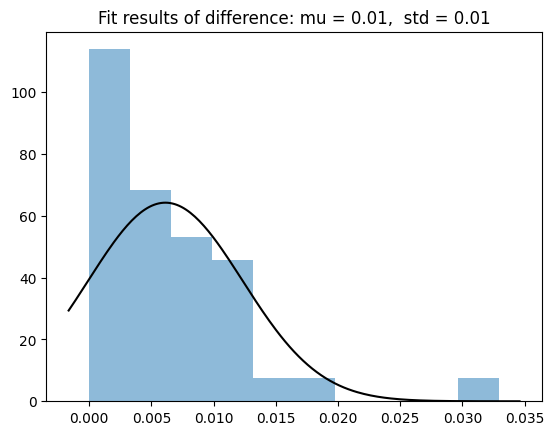

In [59]:
plot_hist(data_A - data_B, "difference")

### t-Test for two paired samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html

**Note**: Only the two-sided p-value is returned!

In [50]:
# Apply the statistical test
res = scipy.stats.ttest_rel(data_A, data_B)
pvalue = res.pvalue

# Compute the correct p-value (two-sided vs. one-sided)
pvalue = compute_pvalue(res.pvalue, np.mean(data_A) - np.mean(data_B), alternative)

# Print results
print_decision(pvalue, alpha)

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.05.


### Wilcoxon Test for two paired samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

In [51]:
# Apply the statistical test
res = scipy.stats.wilcoxon(data_A, data_B, alternative = alternative)

# Print results
print_decision(res.pvalue, alpha)

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.05.


C:\Users\gdela\OneDrive\Documents\AA_Cours\TUW_3S\192.137 Heuristic Optimization Techniques\group_ex\heuritic_optimization_sPlex\venv\Lib\site-packages\scipy\stats\_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Tests for independent samples

Use this section if you have **two independent samples**.

### Visualisation of the distribution of both groups

We check, whether both samples ```data_A - data_B``` are (approximately) normally distributed.
This can be done by plotting a **histogram** for each group.
Furthermore we plot the **density of an estimated normal distribution** 
If the curves approximately follows the corresponding histogram, then normal distribution can be assumed.

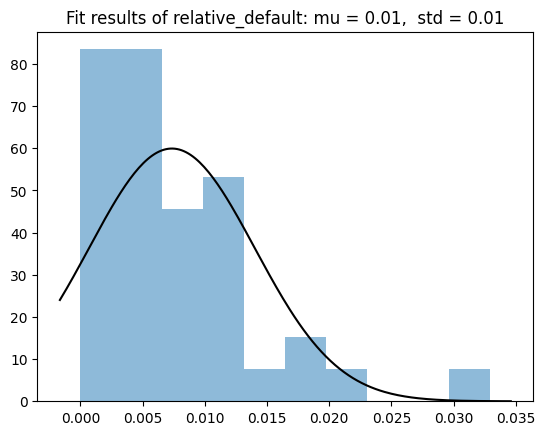

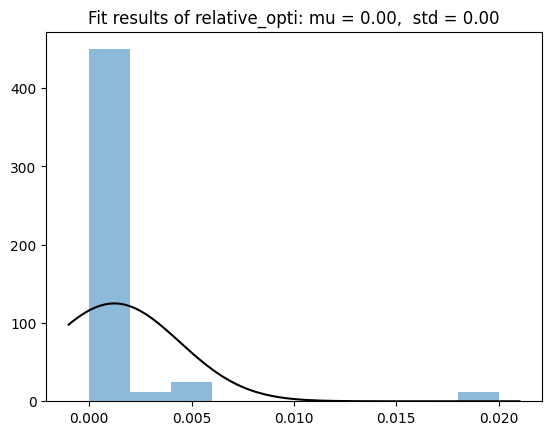

In [52]:
plot_hist(data_A, name_A)
plot_hist(data_B, name_B)

### t-Test for two independent samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

**Note**: Only the two-sided p-value is returned!

In [53]:
# Apply the statistical test
res = scipy.stats.ttest_ind(data_A, data_B)
pvalue = res.pvalue

# Compute the correct p-value (two-sided vs. one-sided)
pvalue = compute_pvalue(res.pvalue, np.mean(data_A) - np.mean(data_B), alternative)

# Print results
print_decision(pvalue, alpha)

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.05.


### U-Test for two independent samples

See https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html

In [54]:
# Apply the statistical test
res = scipy.stats.mannwhitneyu(data_A, data_B, alternative = alternative)

# Print results
print_decision(res.pvalue, alpha)

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.05.
